<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Toxic-Comment-Classification/toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [1]:
import os
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

#bin/bash
!mkdir ~/kaggle
# !mv /content/kaggle1.json /content/kaggle.json
!cp kaggle.json ~/kaggle
!chmod 600 ~/kaggle/kaggle.json
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip jigsaw-toxic-comment-classification-challenge.zip
# !rm -rf jigsaw-toxic-comment-classification-challenge.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory
401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/competitions/data/download-all/jigsaw-toxic-comment-classification-challenge
unzip:  cannot find or open jigsaw-toxic-comment-classification-challenge.zip, jigsaw-toxic-comment-classification-challenge.zip.zip or jigsaw-toxic-comment-classification-challenge.zip.ZIP.


# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# Load & Analyze Data

In [5]:
# Test Data
test = pd.read_csv("test.csv", engine='python', on_bad_lines='warn')
test_labels = pd.read_csv("test_labels.csv")

/tmp/ipython-input-4002880324.py:2: ParserWarning: Skipping line 2583: unexpected end of data

  test = pd.read_csv("test.csv", engine='python', on_bad_lines='warn')


In [6]:
# Train Data
train = pd.read_csv("train.csv", engine='python', on_bad_lines='warn')

/tmp/ipython-input-4281633866.py:2: ParserWarning: Skipping line 2431: unexpected end of data

  train = pd.read_csv("train.csv", engine='python', on_bad_lines='warn')


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2581 entries, 0 to 2580
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            2581 non-null   object
 1   comment_text  2581 non-null   object
dtypes: object(2)
memory usage: 40.5+ KB


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2429 non-null   object
 1   comment_text   2429 non-null   object
 2   toxic          2429 non-null   int64 
 3   severe_toxic   2429 non-null   int64 
 4   obscene        2429 non-null   int64 
 5   threat         2429 non-null   int64 
 6   insult         2429 non-null   int64 
 7   identity_hate  2429 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 151.9+ KB


# Preprocess Data

In [9]:
train = train[['comment_text', 'toxic']].dropna().reset_index(drop=True)
train = train.rename(columns={"comment_text": 'text', 'toxic': 'label'})

# Split to Train/Test/Val

In [10]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    train,
    test_size=0.2,
    random_state=42,
    stratify=train['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 1943
Validation samples: 243
Test samples: 243


# Tokenization

In [11]:
from transformers import AutoTokenizer
from datasets import Dataset

MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128

# Define tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Convert pandas dataframe to HF Dataset object.
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    # The tokenizer handles everything: tokenization, numericalization, padding, truncation
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

print("\n[INFO] Tokenizing all datasets...")
# Using .map() is highly efficient
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

print("\n[INFO] Example of a tokenized sample:")
print(tokenized_train_dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


[INFO] Tokenizing all datasets...


Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]


[INFO] Example of a tokenized sample:
{'text': "Bald Eagle\nI've addressed all your points so far. Cheers, Jude.", 'label': 0, '__index_level_0__': 1122, 'input_ids': [101, 13852, 6755, 1045, 1005, 2310, 8280, 2035, 2115, 2685, 2061, 2521, 1012, 21250, 1010, 12582, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
# Creating Tensorflow DataFrame
BATCH_SIZE = 32

print("\n[INFO] Creating TensorFlow datasets...")

# Convert the tokenized datasets into a format Keras can use
# The input for the model is a dictionary of features
tf_train_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE
)

tf_val_dataset = tokenized_val_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=BATCH_SIZE
)

tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=BATCH_SIZE
)

print("\n[INFO] Data preparation complete! The datasets are now ready for model.fit().")


[INFO] Creating TensorFlow datasets...


/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(



[INFO] Data preparation complete! The datasets are now ready for model.fit().


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Model

# Get the vocabulary size from the Hugging Face tokenizer
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 128  # Dimension for our custom embedding layer
LSTM_UNITS = 64
DROPOUT_RATE = 0.5

print("\n[INFO] Building custom Bi-LSTM model...")

# 1. Define the Input Layer
# The input shape is the max sequence length
input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')

# 2. Define the Embedding Layer (trained from scratch)
# The input_dim is tied to the HF tokenizer's vocabulary.
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    mask_zero=True, # Important for handling padding tokens
    name='embedding_layer'
)(input_ids)

# 3. Define the Recurrent Layer
# Using Bidirectional LSTM for better context understanding
recurrent_layer = Bidirectional(
    LSTM(
        LSTM_UNITS, recurrent_dropout=0.3)
)(embedding_layer)

# 4. Add Dropout and Dense layers
dropout_layer = Dropout(DROPOUT_RATE)(recurrent_layer)
dense_layer = Dense(32, activation='relu')(dropout_layer)

# 5. Define the Output Layer for Regression
# One neuron with a sigmoid activation to output a score between 0 and 1
output_layer = Dense(1, activation='sigmoid', name='output_score')(dense_layer)

# 6. Create the final Model
# Note: The input is only 'input_ids' for this simple model
custom_model = Model(inputs=input_ids, outputs=output_layer)

# --- Compile the model ---
custom_model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Appropriate for regression between 0 and 1
    metrics=['mean_squared_error', 'mean_absolute_error']
)

custom_model.summary()


[INFO] Building custom Bi-LSTM model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 128, 128)  │  3,906,816 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 128)       │          0 │ input_ids[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_score        │ (None, 1)         │         33 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,009,793 (15.30 MB)

 Trainable params: 4,009,793 (15.30 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Adapt the datasets to feed only 'input_ids' to the model
def adapt_dataset_for_custom_model(features, label):
    return features['input_ids'], label

tf_train_dataset_custom = tf_train_dataset.map(adapt_dataset_for_custom_model)
tf_val_dataset_custom = tf_val_dataset.map(adapt_dataset_for_custom_model)
tf_test_dataset_custom = tf_test_dataset.map(adapt_dataset_for_custom_model)

# Train the model
print("\n[INFO] Starting training of the custom model...")
history = custom_model.fit(
    tf_train_dataset_custom,
    validation_data=tf_val_dataset_custom,
    epochs=10, # Custom models may need more epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)


[INFO] Starting training of the custom model...
Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 63s 855ms/step - loss: 0.4887 - mean_absolute_error: 0.3274 - mean_squared_error: 0.1547 - val_loss: 0.2902 - val_mean_absolute_error: 0.1319 - val_mean_squared_error: 0.0853
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 0.2408 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0700 - val_loss: 0.2101 - val_mean_absolute_error: 0.1131 - val_mean_squared_error: 0.0590
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 858ms/step - loss: 0.1101 - mean_absolute_error: 0.0657 - mean_squared_error: 0.0292 - val_loss: 0.2435 - val_mean_absolute_error: 0.0938 - val_mean_squared_error: 0.0621
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 55s 909ms/step - loss: 0.0354 - mean_absolute_error: 0.0261 - mean_squared_error: 0.0079 - val_loss: 0.2730 - val_mean_absolute_error: 0.0829 - val_mean_squared_error: 0.0640
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 51s 837ms/step - loss: 0.0161 - mean_absolute_error: 0.0128 - me


[INFO] Evaluating the custom model on the test dataset...

Test Loss: 0.3726
Test Mean Squared Error (MSE): 0.0640
Test Mean Absolute Error (MAE): 0.0756

[INFO] Plotting training history...


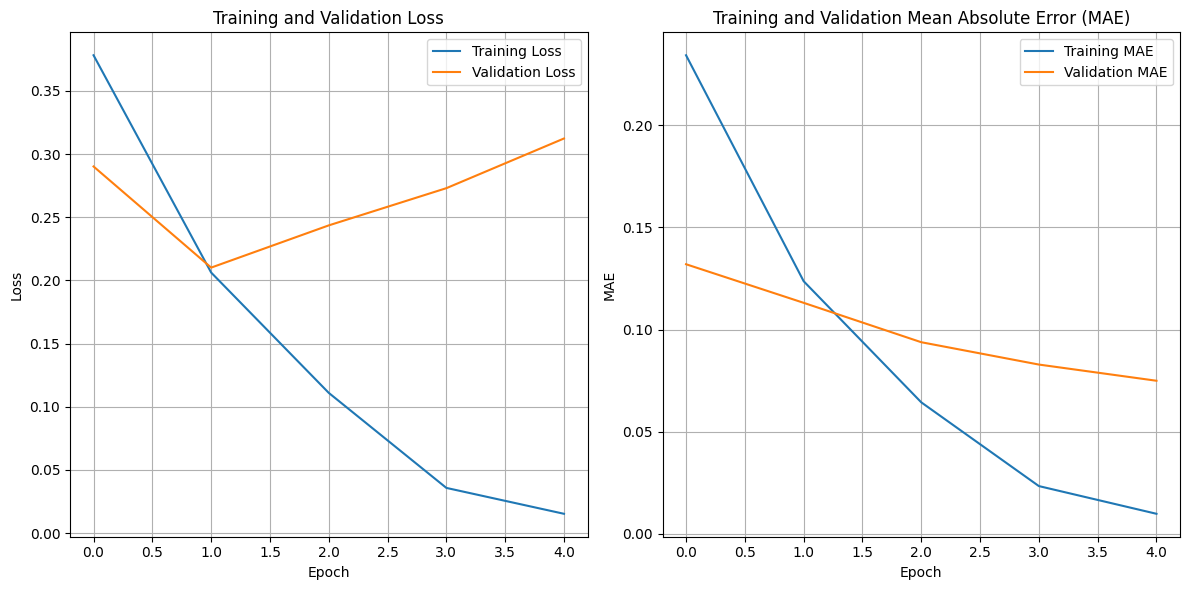


[INFO] Performance analysis complete.


In [15]:
# Evaluate the model on the test dataset
print("\n[INFO] Evaluating the custom model on the test dataset...")
loss, mse, mae = custom_model.evaluate(tf_test_dataset_custom, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

# Plot training history
print("\n[INFO] Plotting training history...")

# Convert history.history to a DataFrame for easier plotting
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history_df['mean_absolute_error'], label='Training MAE')
plt.plot(history_df['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n[INFO] Performance analysis complete.")

## Make predictions
Generate predictions on the `tf_test_dataset_custom` using the trained `custom_model`.


In [16]:
# Generate predictions
print("\n[INFO] Generating predictions on the test dataset...")
predictions = custom_model.predict(tf_test_dataset_custom)

print("\n[INFO] Predictions generated.")


[INFO] Generating predictions on the test dataset...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step

[INFO] Predictions generated.


## Compare predictions and labels


In [17]:
# Convert predictions numpy array to pandas Series
predictions_series = pd.Series(predictions.flatten(), index=test_df.index)

# Add predictions as a new column to test_df
test_df['predicted_label'] = predictions_series

# Display the first few rows of test_df with the new column
display(test_df.head())

,text,label,predicted_label
1880,", 24 December 2008 (UTC)\n\nPerhaps for not th...",0,0.000068
489,"""\n\n Died in 2014 or not? \n\nI think it's be...",0,0.000194
384,The reason is the presence of a template based...,0,0.002986
1609,"You have no friends in real life, what makes y...",1,0.980768
1288,"GHE you're a fag. Learn it, know it!",1,0.817586


## Identify poorly performing samples


In [18]:
# 1. Calculate the absolute difference between the true label and the predicted label
test_df['prediction_error'] = abs(test_df['label'] - test_df['predicted_label'])

# 2. Determine a suitable threshold for identifying poorly performing samples
# Using 0.5 as the threshold for significant error
error_threshold = 0.5

# 3. Identify the rows where the 'prediction_error' is greater than the chosen threshold
poorly_predicted_samples = test_df[test_df['prediction_error'] > error_threshold]

# 4. Store these poorly performing samples in a new DataFrame (already done in step 3)
# Display the first few rows of the poorly predicted samples
display(poorly_predicted_samples.head())

,text,label,predicted_label,prediction_error
1662,Whos the douche that deleated all of the info ...,1,0.005555,0.994445
1165,"""\n\nSo threatening to try to have me banned f...",1,0.006201,0.993799
1149,"Hey, you freaking hermaphrodite. \n\nPlease un...",1,0.001299,0.998701
497,"""""""Nazi filth"""" is impolite 04:27, 20 Jan 200...",1,0.000056,0.999944
2100,It´s blatantly obvious that the only reason wh...,0,0.637245,0.637245


## Display poorly performing samples


In [19]:
# Display the poorly_predicted_samples DataFrame
display(poorly_predicted_samples[['text', 'label', 'predicted_label']].head(20))

,text,label,predicted_label
1662,Whos the douche that deleated all of the info ...,1,0.005555
1165,"""\n\nSo threatening to try to have me banned f...",1,0.006201
1149,"Hey, you freaking hermaphrodite. \n\nPlease un...",1,0.001299
497,"""""""Nazi filth"""" is impolite 04:27, 20 Jan 200...",1,0.000056
2100,It´s blatantly obvious that the only reason wh...,0,0.637245
2195,You are a fool if you think Wikipedia is a res...,1,0.249565
1132,Keep your propaganda away from this article. Y...,0,0.868785
655,Wikipedia administrators are defending a mass-...,1,0.069850
335,"Have you seen the reference to their claim, yo...",1,0.007318
1664,"""\nDRMIES DELETED FRANKIE STEIN FROM MONSTER H...",1,0.002800


## Error Distribution

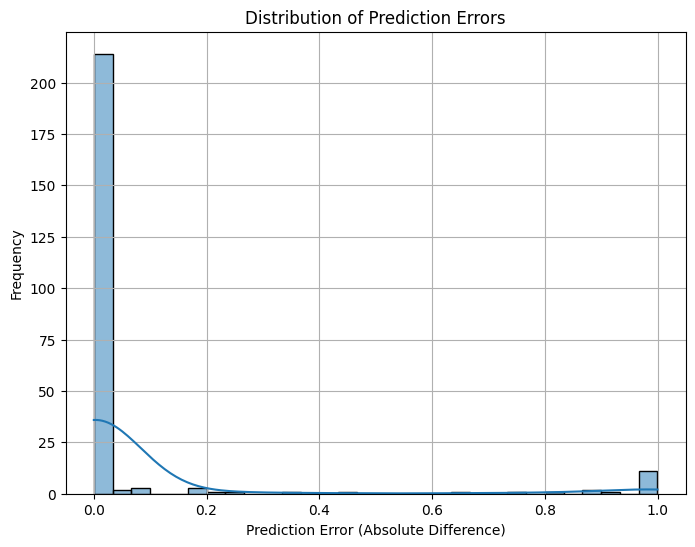

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(test_df['prediction_error'], bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Absolute Difference)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()